<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/Decision_Tree_Model(Rana_Waleed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Decision Tree Model Implementation:
 Based on the paper: "A Comparative Study on Machine Learning Algorithms for Classification"
 MDPI Mathematics, Volume 12, Issue 21, Article 3423
 DOI: https://www.mdpi.com/2227-7390/12/21/3423

**1- Imports and Setup**

In [1]:
# Import required libraries and configure logging
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as ImbPipeline
import shap
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

**2- Logging Configuration**

In [2]:
#  Setup logging to track execution and any issues
logging.basicConfig(filename='output_plots/dt_log.txt', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
logging.info("Starting Decision Tree Model Script")

**3- Output Directory Setup**

In [3]:
# Ensure output directory
output_dir = 'output_plots/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
logging.info(f"Output directory ensured: {output_dir}")

**4- Data Loading**

In [4]:
# Load final dataset
try:
    df_dt = pd.read_csv('final_loan_data_leakproof.csv')
    logging.info("Dataset loaded successfully")
except FileNotFoundError:
    logging.error("Dataset file not found")
    raise

**5- Data Preparation**

In [23]:
# Separate features and target variable
X = df_dt.drop(columns=['target'])
y = df_dt['target']

**6- Train-Test split**

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
#  Ensure train and test sets have the same features
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (40000, 30) Test shape: (10000, 30)


**Observation:**

- The dataset is split into 40,000 training set combined with 10,000 test set, featuring 30 characteristics which demonstrates an appropriate 80:20 ratio for model assessment.



**7- Model Pipeline Definition**

In [7]:
# Create a pipeline with SMOTE and ENN for handling class imbalance
pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.4, random_state=42)),
    ('enn', EditedNearestNeighbours(n_neighbors=3)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

**8- Hyperparameter Grid**

In [8]:
# Define hyperparameters for tuning the decision tree
param_dist = {
    'dt__max_depth': [5, 10, 15, 20, 25],
    'dt__min_samples_split': [2, 5],
    'dt__min_samples_leaf': [1, 2],
    'dt__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:5}, {0:1, 1:10}],
    'dt__criterion': ['gini', 'entropy']
}

**9- Randomized search cv setup**

In [ ]:
#Configure cross-validation search for optimal hyperparameters
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='recall_macro',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

**10- Model Tuning Execution and Tuning Results**

In [9]:
# Execute hyperparameter search with cross-validation
print("\nRunning RandomizedSearchCV for SMOTE+ENN...")
logging.info("Starting RandomizedSearchCV")
random_search.fit(X_train, y_train)
logging.info("RandomizedSearchCV completed")

# Display best parameters and cross-validation scores
score = random_search.best_score_
print(f"Best Score (recall_macro): {score:.3f}")
print(f"Best Parameters: {random_search.best_params_}")


Running RandomizedSearchCV for SMOTE+ENN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Score (recall_macro): 0.624
Best Parameters: {'dt__min_samples_split': 2, 'dt__min_samples_leaf': 1, 'dt__max_depth': 10, 'dt__criterion': 'entropy', 'dt__class_weight': 'balanced'}


**Observation:**

- he RandomizedSearchCV with SMOTE+ENN reached its best recall_macro score of 0.624 when using a decision tree that employed max_depth=10 with entropy criterion and balanced class weights.

**11- CV Score Analysis**

In [10]:
# Analyze cross-validation score variability
cv_scores = random_search.cv_results_['mean_test_score']
print(f"CV Scores (recall_macro): Mean = {cv_scores.mean():.3f}, Std = {cv_scores.std():.3f}")
logging.info(f"CV Scores: Mean = {cv_scores.mean():.3f}, Std = {cv_scores.std():.3f}")


CV Scores (recall_macro): Mean = 0.574, Std = 0.023


**Observation**

- The cross-validation recall_macro scores measured 0.574 mean performance while demonstrating low standard deviation of 0.023 across folds

**12- Test Set Evaluation**

In [11]:
# Evaluate on test set
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
print("\nSMOTE+ENN Test Set Results:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
logging.info("Evaluated SMOTE+ENN on test set")


SMOTE+ENN Test Set Results:
              precision    recall  f1-score   support

           0       0.86      0.74      0.80      7977
           1       0.33      0.51      0.40      2023

    accuracy                           0.70     10000
   macro avg       0.60      0.63      0.60     10000
weighted avg       0.75      0.70      0.72     10000

AUC-ROC: 0.681


**OBSERVATION**
- The decision tree built through SMOTE+ENN reached 70% test set accuracy along with AUC-ROC of 0.681 yet its precision (0.86) was high while its recall (0.51) for defaults remained low.

**13- Best Model Extraction**

In [ ]:
#Extract the best model from the pipeline for further analysis
best_dt = random_search.best_estimator_
dt_model = best_dt.named_steps['dt']

**14- Detailed Model Evaluation**

In [12]:
# Evaluate best model
y_pred = best_dt.predict(X_test)
y_pred_proba = best_dt.predict_proba(X_test)[:, 1]
print("\n" + "="*50)
print("Best Decision Tree Results (Test Set)")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Fully Paid', 'Default']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
logging.info("Evaluated best Decision Tree on test set")


Best Decision Tree Results (Test Set)
              precision    recall  f1-score   support

  Fully Paid       0.86      0.74      0.80      7977
     Default       0.33      0.51      0.40      2023

    accuracy                           0.70     10000
   macro avg       0.60      0.63      0.60     10000
weighted avg       0.75      0.70      0.72     10000

AUC-ROC: 0.681


**Observation**
- The SMOTE+ENN model produced the best decision tree that reached 70% accuracy and 0.681 AUC-ROC value on the test set and exhibited 0.86 precision for Fully Paid loans compared to 0.51 recall for Defaults.

**15- Confusion Matrix Visualization**

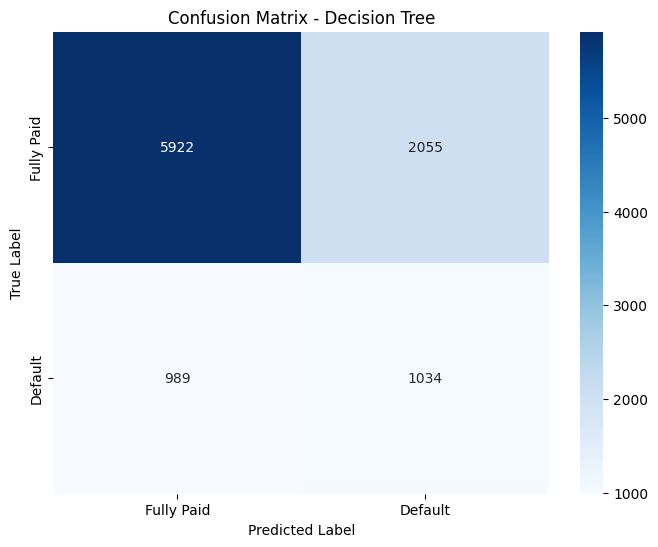

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'{output_dir}/dt_confusion_matrix.png')
plt.show()
logging.info("Saved confusion matrix")

**Observation**
- Overall analysis from the confusion matrix reveals correct predictions for 5922 Fully Paid loans and 1034 Defaulted loans while the decision tree incorrectly classified 2055 Fully Paid loans as Defaults and 989 Defaulted loans as Fully Paid and this indicates the need for improved prediction ability for the minority Defaulted class.

 **16- Results Presistence**

In [14]:
# Save results
with open(f'{output_dir}/dt_results.txt', 'w') as f:
    f.write("Best Pipeline: SMOTE+ENN\n")
    f.write("\nBest Parameters:\n")
    f.write(str(random_search.best_params_))
    f.write("\n\nClassification Report:\n")
    f.write(classification_report(y_test, y_pred))
    f.write(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
logging.info("Saved results to dt_results.txt")

**17- Feature Importance Analysis and visusalization**


Feature Importance
                    Feature  Importance
3                     grade    0.668629
19           loan_to_income    0.088870
14             issue_d_year    0.028317
25  home_ownership_MORTGAGE    0.025146
5                annual_inc    0.021638
23          term_ 60 months    0.014277
1               installment    0.014222
11                revol_bal    0.013849
8            inq_last_6mths    0.012667
20                dti_ratio    0.012300


<ipython-input-15-806c46b7a7d4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance.head(10), palette='viridis')


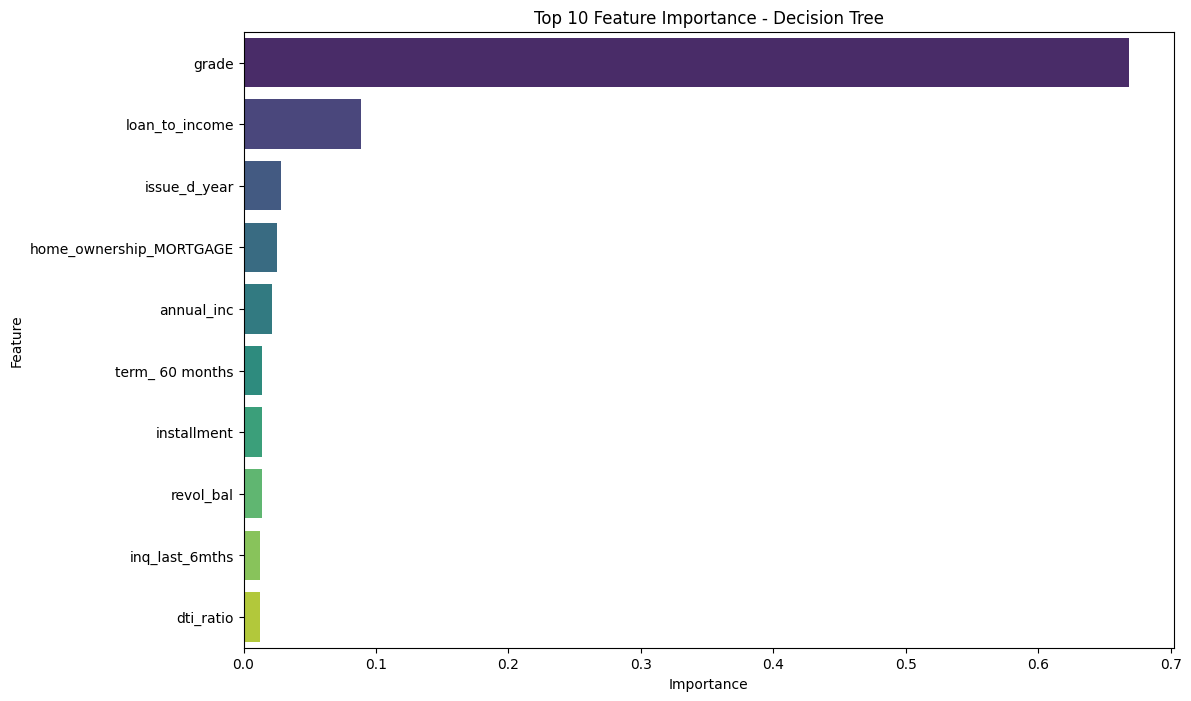

In [15]:
# Analyze which features most influence model decisions
model_features = X_train.columns.tolist()
importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n" + "="*50)
print("Feature Importance")
print("="*50)
print(importance.head(10))

# Create and save bar chart of top feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance.head(10), palette='viridis')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.savefig(f'{output_dir}/dt_feature_importance.png')
plt.show()
logging.info("Saved feature importance plot")

**Observation**
- The loan grade stands as the most significant predictive factor which explains 66% of the model strength and loan-to-income ratio trails behind with 9% power.
- The issue year and home ownership parameter coupled with annual income together form a minor part (under 3% each) in the model predictions.

**18- Decision Tree Visualization**

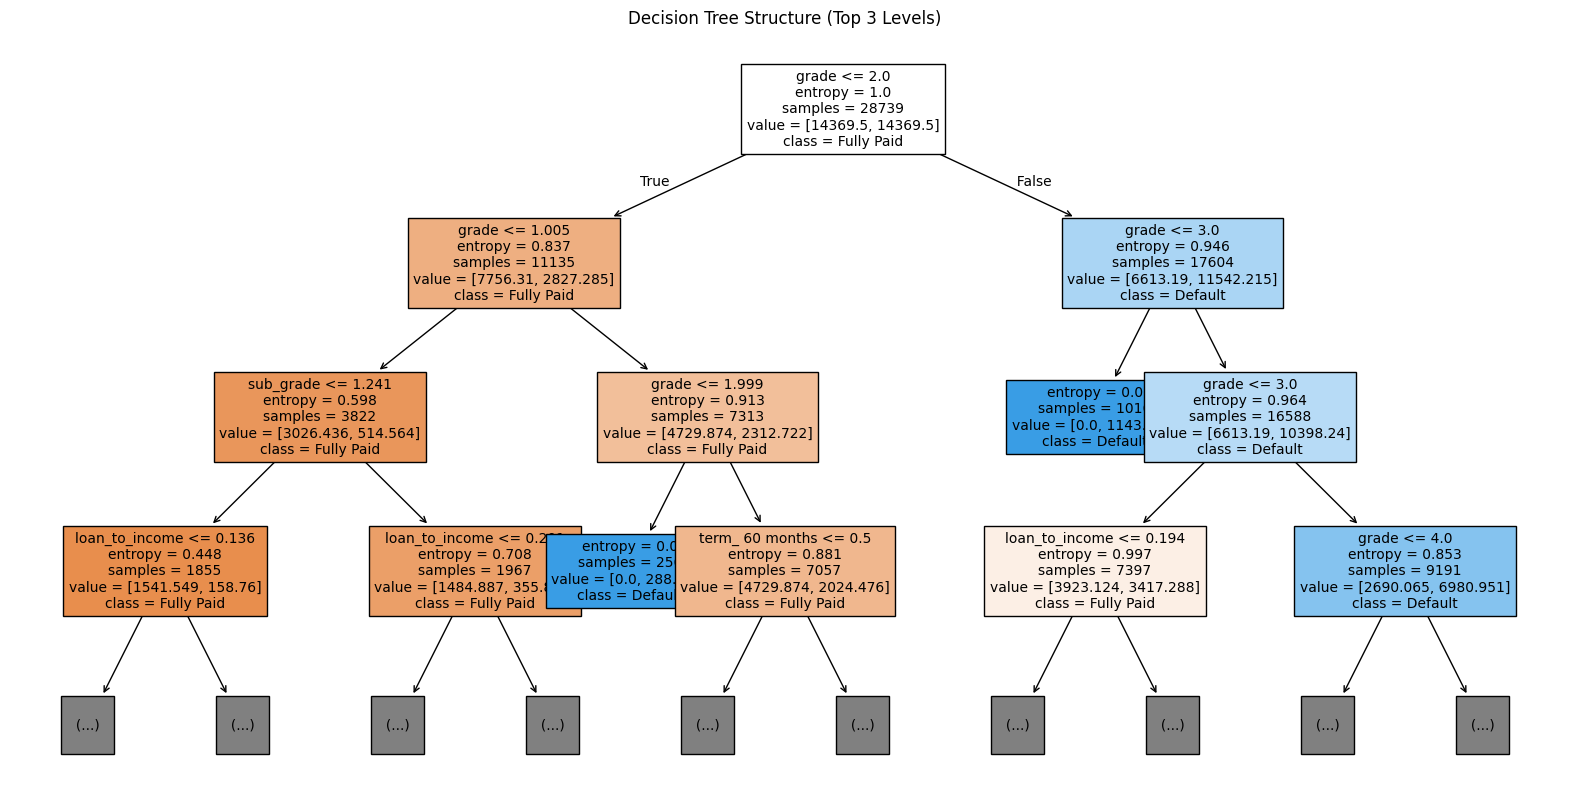

In [16]:
# Visualize the structure of the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, max_depth=3, feature_names=model_features,
          class_names=['Fully Paid', 'Default'], filled=True, fontsize=10)
plt.title('Decision Tree Structure (Top 3 Levels)')
plt.savefig(f'{output_dir}/dt_structure.png')
plt.show()
logging.info("Saved decision tree structure")

**Observation**

- According to the decision tree all top levels use grade as the primary determinant to split loan repayment predictions. Grade levels at 2.0 or lower together with a ratio of ≤1.005 point toward "Fully Paid" outcomes yet grade levels above 3.0 usually result in "Default" decisions where loan_to_income ratio frequently serves as a significant indicator across multiple classification branches.

**19- SHAP Analysis Setup, Output Handling  and Summary Visualization**

In [17]:
# SHAP Values
print("\nComputing SHAP values...")
logging.info("Computing SHAP values")
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_test)


Computing SHAP values...


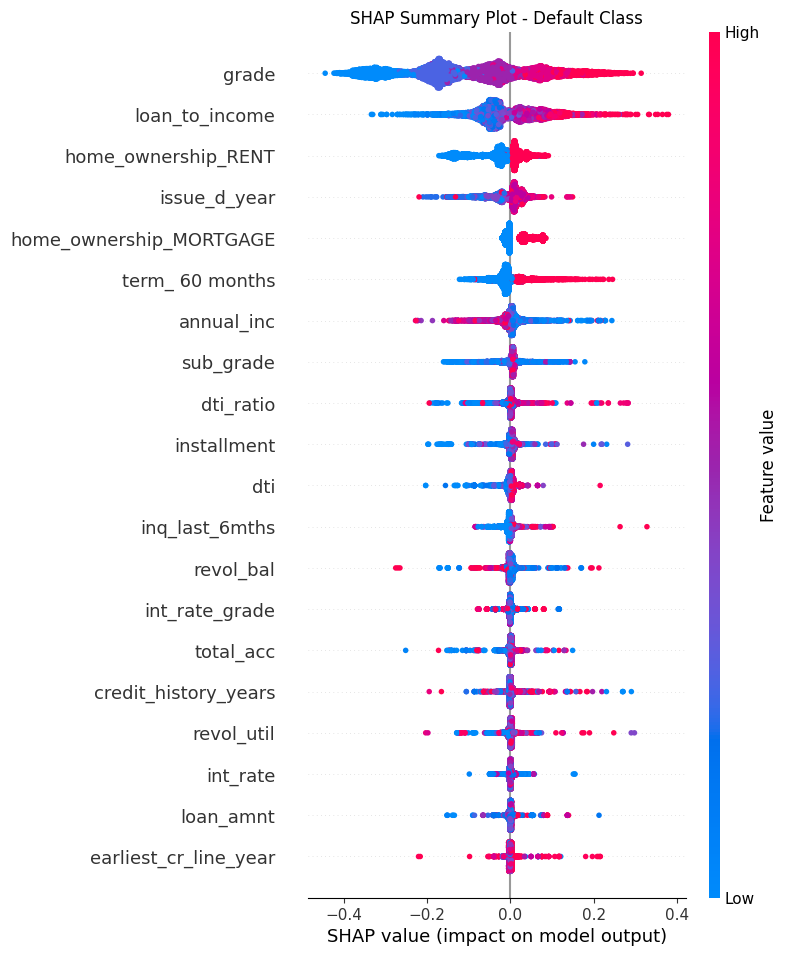

In [18]:
# Handle SHAP output
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values[:, :, 1] if shap_values.ndim == 3 else shap_values

# SHAP Summary Plot
plt.figure()
shap.summary_plot(shap_values_class1, X_test, feature_names=model_features, show=False)
plt.title('SHAP Summary Plot - Default Class')
plt.savefig(f'{output_dir}/dt_shap_summary.png')
plt.show()
logging.info("Saved SHAP summary plot")

**Observation**
- The SHAP summary plot examines grade and loan_to_income features because they affect loan default predictions most strongly through red higher value segments that lead to default outcomes together with blue lower value segments that steer away from default.
- The variables home_ownership_RENT, term_60 months, and issue_d_year show an impact on predictions which matches the decision tree feature importance measurements.

<Figure size 640x480 with 0 Axes>

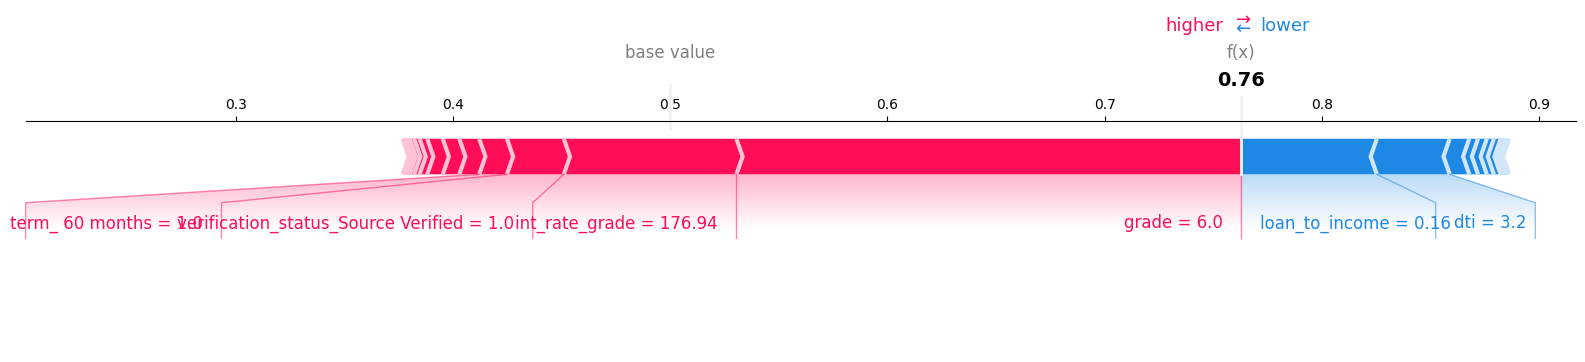

<Figure size 640x480 with 0 Axes>

In [19]:
# SHAP Force Plot
high_risk_idx = y_test[y_test == 1].index[0] if 1 in y_test.values else 0
plt.figure()
shap.force_plot(explainer.expected_value[1], shap_values_class1[high_risk_idx],
                X_test.iloc[high_risk_idx], feature_names=model_features, matplotlib=True)
plt.savefig(f'{output_dir}/dt_shap_force.png')
plt.show()
logging.info("Saved SHAP force plot")

**Observation**
- The SHAP force plot demonstrates a loan with 0.76 default probability which falls due to 60-month term along with a verified source and high interest rate grade and 6.0 grade (red).
- The default probabilities remain high (0.76) when only specific ratios decrease to 0.16 loan_to_income and 3.2 debt-to-income although these favorable factors are not enough to offset other negative indicators.

**20- Partial Dependences plots**

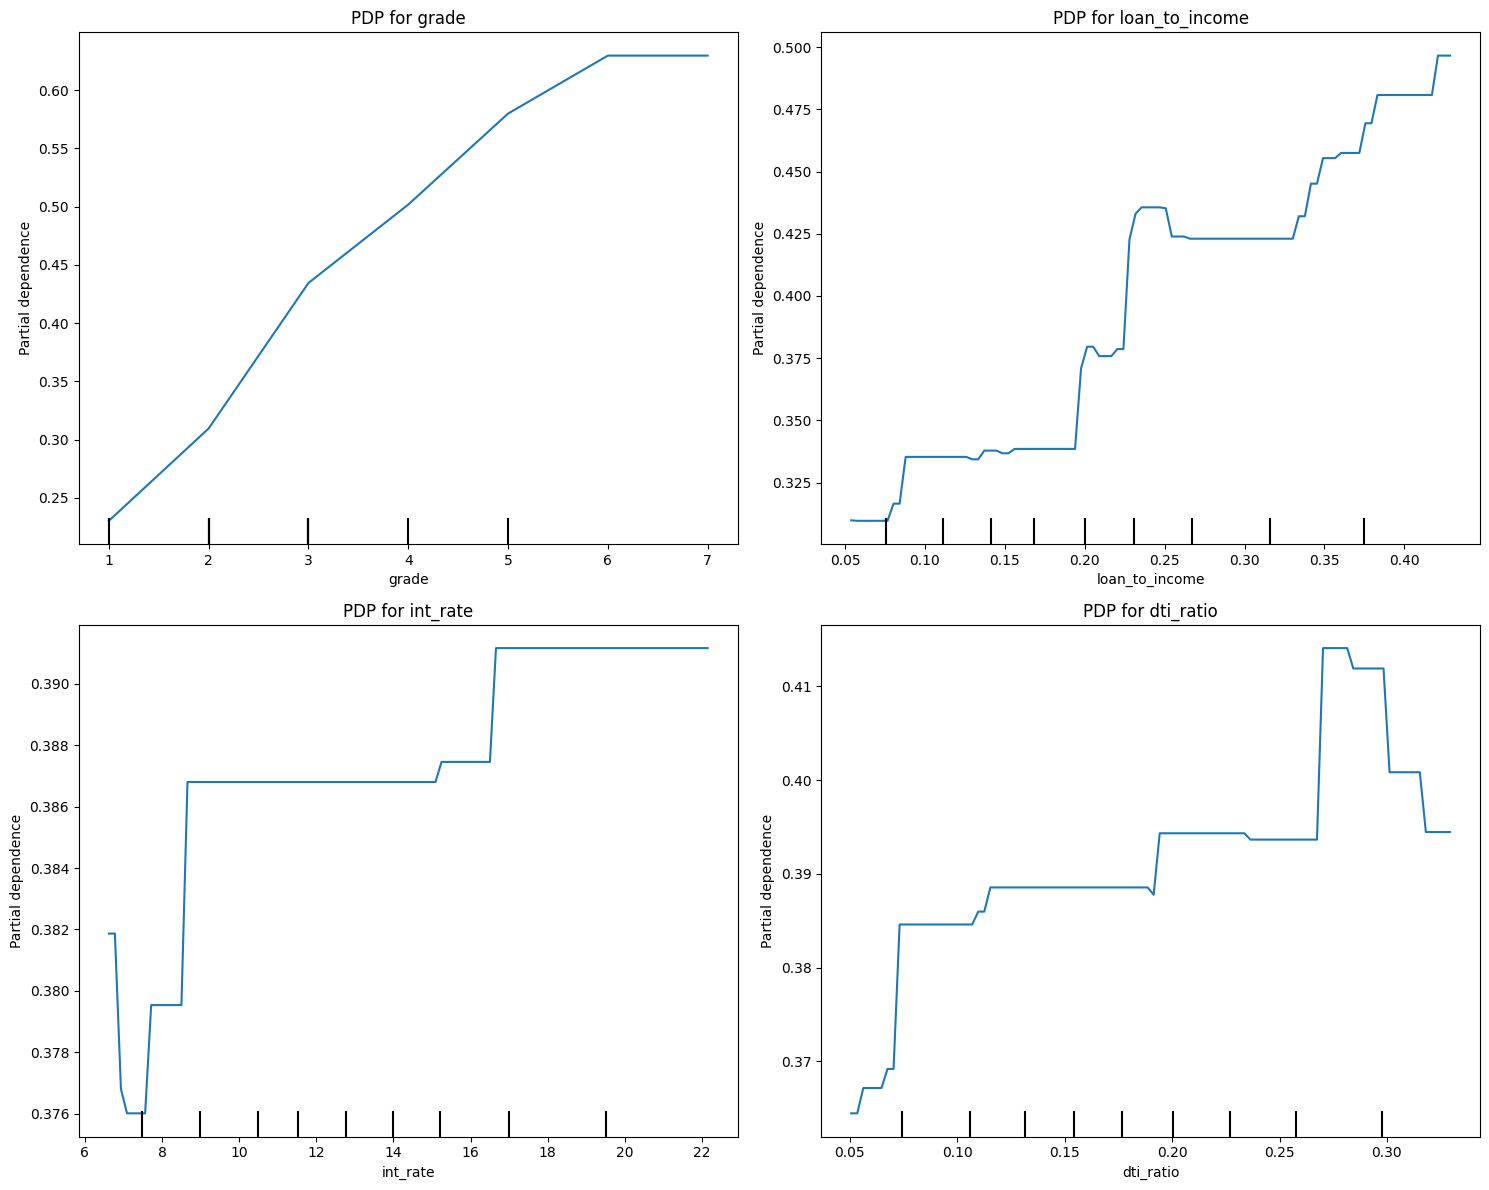

In [20]:
# Partial Dependence Plots : Analyze how predictions change with changes in feature values
numerical_features = ['int_rate', 'dti_ratio', 'loan_to_income', 'dti', 'loan_amnt', 'sub_grade', 'grade']
top_features = [f for f in importance['Feature'].head(4).values if f in numerical_features]
if len(top_features) < 4:
    top_features.extend([f for f in numerical_features if f in X_train.columns and f not in top_features][:4-len(top_features)])

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()
for i, feature in enumerate(top_features[:4]):
    try:
        PartialDependenceDisplay.from_estimator(
            dt_model, X_train, features=[feature], kind='average',
            ax=axes[i], random_state=42
        )
        axes[i].set_title(f'PDP for {feature}')
        axes[i].grid(True)
    except Exception as e:
        print(f"Warning: PDP failed for {feature}: {str(e)}")
        logging.warning(f"PDP failed for {feature}: {str(e)}")
        axes[i].set_title(f'PDP Skipped for {feature}')
        axes[i].axis('off')
plt.tight_layout()
plt.savefig(f'{output_dir}/dt_pdp.png')
plt.show()
logging.info("Saved partial dependence plots")

**Observation**
- The PDP plot indicate that default chances rise progressively with grade levels (producing the greatest change from 0.23 to 0.63) along with multiple threshold points at loan_to_income levels starting at 0.2 and above 0.35.
- Default probability experiences moderate changes at specific threshold points where interest rate and DTI ratio reach particular levels.

**21- Ensemble Benchmarking**

In [21]:
# Compare decision tree with ensemble methods
print("\n" + "="*50)
print("Voting Classifier Benchmarking")
print("="*50)
voting_clf = VotingClassifier(
    estimators=[
        ('dt', best_dt),
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(random_state=42))
    ],
    voting='soft'
)
logging.info("Starting Voting Classifier training")
voting_clf.fit(X_train, y_train)
logging.info("Voting Classifier training completed")
y_pred_voting = voting_clf.predict(X_test)
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]
print("\nVoting Classifier Results:")
print(classification_report(y_test, y_pred_voting, target_names=['Fully Paid', 'Default']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_voting):.3f}")
logging.info("Evaluated Voting Classifier")



Voting Classifier Benchmarking

Voting Classifier Results:
              precision    recall  f1-score   support

  Fully Paid       0.82      0.93      0.87      7977
     Default       0.45      0.22      0.30      2023

    accuracy                           0.79     10000
   macro avg       0.64      0.58      0.59     10000
weighted avg       0.75      0.79      0.76     10000

AUC-ROC: 0.704


**Observation**

- The model achieves 79% accuracy across the board while delivering superior results in detecting complete fully paid loans (93% recall) than recognizing defaults (only 22% recall) due to an underlying class distribution imbalance issue. With an AUC-ROC of 0.704.

In [22]:
# Save ensemble results
with open(f'{output_dir}/voting_results.txt', 'w') as f:
    f.write("Voting Classifier (DT + RF + XGB)\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_test, y_pred_voting))
    f.write(f"\nAUC-ROC: {roc_auc_score(y_test, y_pred_proba_voting):.3f}")
logging.info("Saved Voting Classifier results to voting_results.txt")